In [51]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.interpolate import interp1d
from scipy.integrate import solve_ivp
from scipy.signal import savgol_filter

In [52]:
# Previous Model (John Tyson, 2023)

def previous_odes(t, state, scale_factor):

    E, M = state
    
    beta = (beta_0 * K ** n + beta_1 * E ** n) / (K ** n + E ** n)
    
    dE_dt = A * E**2 - B * E + C_ptth + C_iis * M
    dM_dt = (alpha * scale_factor) * M * np.log(M0 * np.exp(beta) / M)

    return [dE_dt, dM_dt]


A = 0.0225
alpha = 0.09
B = 0.12
beta_0 = 2.1
beta_1 = 1.5
C_ptth = 0.018
C_iis = 0.12
E0 = 0.496
K = 10
M0 = 0.3
n = 2

i0 = [E0, M0]


t_end = 200
t_eval = np.linspace(0, t_end, 2000)


factors = np.linspace(0, 3, 100)
pupation_times_previous = []
max_masses_previous = []

for factor in tqdm(factors):
    sol = solve_ivp(previous_odes, (0, t_end), i0,
                    args=(factor,),
                    t_eval=t_eval, max_step=0.01)
    E_val = sol.y[0]
    M_val = sol.y[1]
    t_val = sol.t
    
    if E_val[-1] > 20:
        pupation_times_previous.append(t_val[-1])
        max_masses_previous.append(M_val.max())
    else:
        pupation_times_previous.append(np.nan)
        max_masses_previous.append(np.nan)


pupation_times_previous = np.array(pupation_times_previous)

100%|██████████| 100/100 [01:02<00:00,  1.60it/s]


In [53]:
# Simple Model

def pulse(x,A,ti,tf):
    return np.where(ti <= x <= tf, A, 0)


def simple_odes(t, i, Amp, ti, tf, scale_factor, x_stop):

    x, y = i
    F = 1 if x <= x_stop else 0

    dxdt = (1/2) * x**2 - x + (1/2) * y + pulse(t, Amp, ti, tf)
    dydt = (epsilon * scale_factor) * F

    return [dxdt, dydt]



epsilon = 1.027
x_stop = 1.489
t0 = 0
t1 = 9
i0 = [0, 0]
t_end = 100
t_span = (0, t_end)
t_eval = np.linspace(0, t_end, 1000)


factors = np.linspace(0, 3, 1000)
pupation_times = []
max_masses = []

for factor in tqdm(factors):
    sol = solve_ivp(simple_odes, t_span, i0,
                    args=(0, t0, t1, factor, x_stop),
                    t_eval=t_eval, max_step=0.01)
    x_val = sol.y[0]
    y_val = sol.y[1]
    t_val = sol.t
    
    if x_val[-1] > 20:
        pupation_times.append(t_val[-1]*60/4.704704704704705)
        max_masses.append(y_val[-1])
    else:
        pupation_times.append(np.nan)
        max_masses.append(np.nan)


pupation_times = np.array(pupation_times)
pupation_times_simple = savgol_filter(pupation_times[4:], window_length=101, polyorder=1)

100%|██████████| 1000/1000 [01:16<00:00, 13.15it/s]


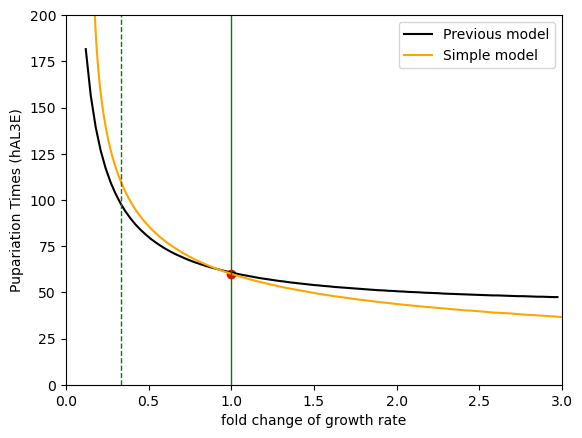

In [ ]:
# Model Comparison

plt.plot(factors[::10], pupation_times_previous, linestyle='-', c='black', label='Previous model')
plt.plot(factors[4:], pupation_times_simple, linestyle='-', c='orange', label='Simple model')
plt.axvline(x=1, color='green', linestyle='-', linewidth=1)
plt.axvline(x=0.3333, color='green', linestyle='--', linewidth=1)
plt.scatter(x=1, y=60, color='red', marker='o')
plt.xlabel("fold change of growth rate")
plt.ylabel("Pupariation Times (hAL3E)")
plt.xlim(left=0, right=3)
plt.ylim(bottom=0, top=200)
plt.legend()
plt.show()

98.14907453726863


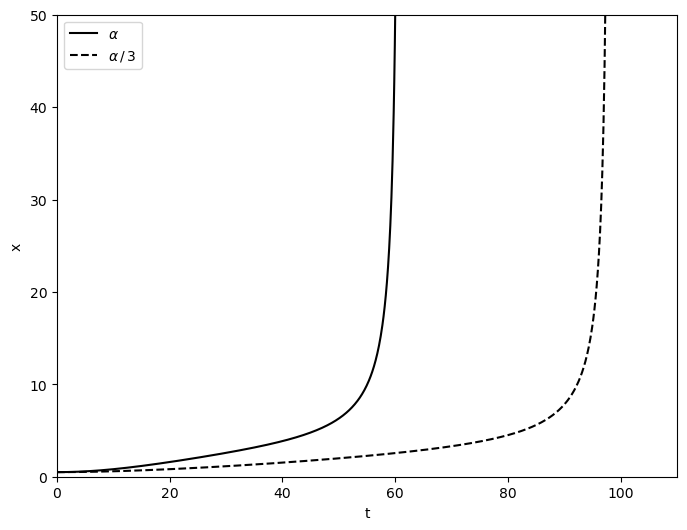

In [ ]:
def previous_odes(t, state, scale_factor):

    E, M = state
    
    beta = (beta_0 * K ** n + beta_1 * E ** n) / (K ** n + E ** n)
    
    dE_dt = A * E**2 - B * E + C_ptth + C_iis * M
    dM_dt = (alpha * scale_factor) * M * np.log(M0 * np.exp(beta) / M)

    return [dE_dt, dM_dt]


A = 0.0225
alpha = 0.09
B = 0.12
beta_0 = 2.1
beta_1 = 1.5
C_ptth = 0.018
C_iis = 0.12
E0 = 0.496
K = 10
M0 = 0.3
n = 2

i0 = [E0, M0]


t_end = 200
t_eval = np.linspace(0, t_end, 2000)

sol_previous1 = solve_ivp(previous_odes, (0, t_end), i0, args=(1,), t_eval=t_eval, max_step=0.01)
E_val_previous1 = sol_previous1.y[0]
M_val_previous1 = sol_previous1.y[1]
t_val_previous1 = sol_previous1.t

sol_previous2 = solve_ivp(previous_odes, (0, t_end), i0, args=(0.33333,), t_eval=t_eval, max_step=0.01)
E_val_previous2 = sol_previous2.y[0]
M_val_previous2 = sol_previous2.y[1]
t_val_previous2 = sol_previous2.t

print(t_val_previous2[-1])

plt.figure(figsize=(8, 6))
plt.plot(t_val_previous1, E_val_previous1, label=r'$\alpha$', color='black', marker='', linestyle='-')
plt.plot(t_val_previous2, E_val_previous2, label=r'$\alpha \, / \, 3$', color='black', marker='', linestyle='--')
plt.xlabel('t')
plt.ylabel('x')
plt.xlim(left=0, right=110)
plt.ylim(bottom=0, top=50)
plt.legend()
plt.show()

105.95744680851064


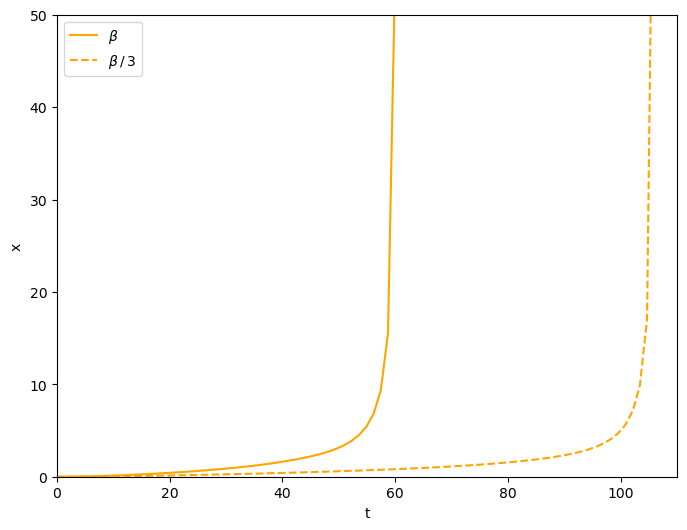

In [ ]:
def pulse(x,A,ti,tf):
    return np.where(ti <= x <= tf, A, 0)


def simple_odes(t, i, Amp, ti, tf, scale_factor, x_stop):

    x, y = i
    F = 1 if x <= x_stop else 0

    dxdt = (1/2) * x**2 - x + (1/2) * y + pulse(t, Amp, ti, tf)
    dydt = (epsilon * scale_factor) * F

    return [dxdt, dydt]



epsilon = 1.027
x_stop = 1.489
t0 = 0
t1 = 9
i0 = [0, 0]
t_end = 100
t_span = (0, t_end)
t_eval = np.linspace(0, t_end, 1000)


sol_simple1 = solve_ivp(simple_odes, t_span, i0, args=(0, t0, t1, 1, x_stop), t_eval=t_eval, max_step=0.01)
E_val_simple1 = sol_simple1.y[0]
M_val_simple1 = sol_simple1.y[1]
t_val_simple1 = sol_simple1.t

sol_simple2 = solve_ivp(simple_odes, t_span, i0, args=(0, t0, t1, 0.33333, x_stop), t_eval=t_eval, max_step=0.01)
E_val_simple2 = sol_simple2.y[0]
M_val_simple2 = sol_simple2.y[1]
t_val_simple2 = sol_simple2.t

print(t_val_simple2[-1]*60/4.704704704704705)

plt.figure(figsize=(8, 6))
plt.plot(t_val_simple1*60/4.704704704704705, E_val_simple1, label=r'$\beta$', color='orange', marker='', linestyle='-')
plt.plot(t_val_simple2*60/4.704704704704705, E_val_simple2, label=r'$\beta \, / \, 3$', color='orange', marker='', linestyle='--')
plt.xlabel('t')
plt.ylabel('x')
plt.xlim(left=0, right=110)
plt.ylim(bottom=0, top=50)
plt.legend()
plt.show()

4.734734734734735
advancement: -18.64693446088794
advancement: 17.88583509513742


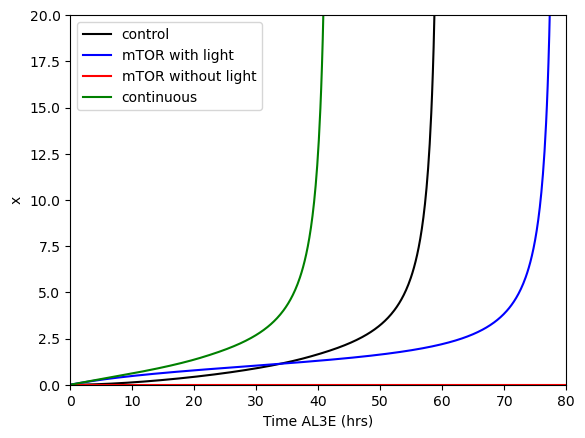

In [ ]:
# mTOR experiment predictions

def pulse(x,A,ti,tf):
    return np.where(ti <= x <= tf, A, 0)

def control_odes(t, i, Amp, ti, tf, epsilon, x_stop):

    x, y = i
    F = 1 if x <= x_stop else 0

    dxdt = (1/2) * x**2 - x + (1/2) * y + pulse(t, Amp, ti, tf)
    dydt = epsilon * F

    return [dxdt, dydt]

def mTOR_odes(t, i, Amp, ti, tf, epsilon, x_stop):

    x, y = i
    F = 1 if x <= x_stop else 0

    dxdt = (1/2) * x**2 - x + pulse(t, Amp, ti, tf)

    return [dxdt]

# Initial value of E
x_stop = 1.4893
amplitude = 0.8165
t0 = 0
t1 = 10

epsilon = 1.0270
i0 = [0, 1e-15]

# Start and end time
t_end = 10
t_span = (0, t_end) 


solution_control = solve_ivp(control_odes, t_span, i0, args=(0, t0, t1, epsilon, x_stop), t_eval=np.linspace(0, t_end, 1000), max_step=0.01)
t_control = solution_control.t
x_control = solution_control.y[0]
y_control = solution_control.y[1]
target_t_0 = t_control[-1]
print(target_t_0)

solution_mTOR = solve_ivp(mTOR_odes, t_span, i0, args=(amplitude, t0, t1, epsilon, x_stop), t_eval=np.linspace(0, t_end, 1000), max_step=0.01)
t_mTOR = solution_mTOR.t
x_mTOR = solution_mTOR.y[0]
t_last = t_mTOR[-1]
print("advancement:", (target_t_0-t_last)*60/target_t_0)

solution_noInsulin = solve_ivp(mTOR_odes, t_span, i0, args=(0, t0, t1, epsilon, x_stop), t_eval=np.linspace(0, t_end, 1000), max_step=0.01)
t_noInsulin = solution_noInsulin.t
x_noInsulin = solution_noInsulin.y[0]

solution_light = solve_ivp(control_odes, t_span, i0, args=(amplitude, t0, t1, epsilon, x_stop), t_eval=np.linspace(0, t_end, 1000), max_step=0.01)
t_light = solution_light.t
x_light = solution_light.y[0]
y_light = solution_light.y[1]
t_last = t_light[-1]
print("advancement:", (target_t_0-t_last)*60/target_t_0)


plt.plot(t_control*60/target_t_0, x_control, color = "black", label="control")
plt.plot(t_mTOR*60/target_t_0, x_mTOR, color = "blue", label="mTOR with light")
plt.plot(t_noInsulin*60/target_t_0, x_noInsulin, color = "red", label="mTOR without light")
plt.plot(t_light*60/target_t_0, x_light, color = "green", label="continuous")
plt.xlabel("Time AL3E (hrs)")
plt.ylabel("x")
plt.xlim(left=0, right=80)
plt.ylim(bottom=0, top=20)
plt.legend()
plt.show()

In [ ]:
# Fig 2C, Fig S1

# Log-rank test
from lifelines.statistics import logrank_test

# data written in the form of np.array([pupation-time-of-one-individual, ...])
T_control = # control data
T_light = # treatment data

E_control = np.ones_like(T_control)  # all events observed
E_light = np.ones_like(T_light)

result = logrank_test(T_control, T_light, event_observed_A=E_control, event_observed_B=E_light)

print("p-value:", result.p_value)
print("test statistic:", result.test_statistic)